# Задание 1


Попробовать решить задачу регресии для набора данных по пауэрлифитингу, но для женщин ( df[df['Sex'] =='F'] ) и попробовать выбрать иные целевые переменные из "BodyweightKg", "Age", "Equipment", "Tested", "bench", 'deadlift', 'squat'.

Для каждой целевой переменной посчитать метрики MAE, MAPE, MSE, RMSE, R2.

Строить регрессию как на всех данных целиком с помощью statsmodels, так и с помощью кросс-валидации и пакета sklearn (встроенная модель LinearRegression) (попробовать оба варианта)

## Подготовка данных

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# statsmodels.api использует нотацию numpy
# statsmodels.formula.api использует формульную нотацию (наподобие нотации языка R)
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tools.eval_measures import rmse
np.random.seed(2077)

Импорт данных по пауэрлифтингу

In [2]:
from google.colab import output

# Скачиваем архив с данными с яндекс-диска с помощью скрипта на гитхабе
# скачиваем скрипт коммандой wget
!wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
# устанавливаем разрешение на исполнение скрипта
!chmod +x ya.py
# выполняем скрипт, в параметрах указав ссылку на скачивание
!./ya.py https://disk.yandex.ru/d/2QBkfBsLyFt5Gw
# распаковываем архив
!unzip powerlifting.zip
output.clear()

In [3]:
df = pd.read_csv("openpowerlifting.csv")

<ipython-input-3-e5d7ef63ed4a>:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("openpowerlifting.csv")


In [4]:
# Посмотрим какие есть колонки в наборе данных
print(df.columns)
# Проверим размерность таблицы с данными с помощь .shape (работает как для pandas, так и numpy)
print(df.shape)

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division',
       'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg',
       'Squat4Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
       'Bench4Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg',
       'Deadlift4Kg', 'Best3DeadliftKg', 'TotalKg', 'Place', 'Wilks',
       'McCulloch', 'Glossbrenner', 'IPFPoints', 'Tested', 'Country',
       'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetName'],
      dtype='object')
(1423354, 37)


### Структура реальных данных


Каждая строка в наборе данных - это данные о результатах какого-либо спортсмена на каком-либо соревновании.

Структура колонок:
1. Name - Имя спортсмена
2. Sex - пол
3. Event - Какие виды упражнений выполнялись на соревновании. SBD (Squat, Bench, Deadlift - присяд со штангой, жим штанги лежа, становая тяга) это тройка стандартных силовых упражнений, но могут быть соревнования по отдельным упражнениям.
4. Equipment - Какая использовалась экипировка (Single-Ply and Multi-Ply - комбинезоны или майки, однослойные или многослойные, Wraps - бинты, Straps - лямки для тяги)
5. Age - Возраст спортсмена
6. AgeClass - Возрастная группа.
7. Division - тип соревнования (открытый, юношеский и т.д.)
8. BodyweightKg - Вес спортсмена
9. WeightClassKg - Весовая категория (до х лет).
10. Squat1Kg - Первая попытка присяда со штангой на соревновании для спортсмена, кг. Отрицательные значения означают, что выполнить упражнение с таким весом не удалось. NaN - что упражнение или попытка не выполнялись.
11. Squat2Kg - Вторая попытка присяда со штангой, кг.
12. Squat3Kg - Третья попытка присяда со штангой, кг
13. Squat4Kg - Четвертая попытка присяда со штангой, кг. Используется редко.
14. Best3SquatKg - Лучшая попытка из [Squat1Kg, Squat2Kg, Squat3Kg]. Только это значение учитывается для упражнения в зачет параметра TotalKg
15. Bench1Kg - Первая попытка жима лежа со штангой, кг.
16. Bench2Kg - Вторая попытка жима лежа со штангой, кг.
17. Bench3Kg - Третья попытка жима лежа со штангой, кг.
18. Bench4Kg - Четвертая попытка жима лежа со штангой, кг. Используется редко.
19. Best3BenchKg - Лучшая попытка из [Bench1Kg, SquatBench2KgKg, Bench3Kg]. Только это значение учитывается для упражнения в зачет параметра TotalKg
20. Deadlift1Kg - Первая попытка становой тяги, кг.
21. Deadlift2Kg - Вторая попытка становой тяги, кг.
22. Deadlift3Kg - Третья попытка становой тяги, кг.
23. Deadlift4Kg - Четвертая попытка становой тяги, кг. Используется редко.
24. Best3DeadliftKg - Лучшая попытка из [Deadlift1Kg, Deadlift2Kg, Deadlift3Kg]. Только это значение учитывается для упражнения в зачет параметра TotalKg
25. TotalKg - The sum of Best3SquatKg, Best3BenchKg, Best3DeadliftKg
26. Place - Какое место занял спортсмен на соревновании
27. -- 30. Wilks, McCulloch, Glossbrener, IPFPoints - Различные формулы для определения лучшего спортсмена
31. Tested - проводился ли допинг-контроль
32. Country - Страна спортсмена
33. Federation - федерация, под чьей эгидой проводилось соревнование
34. Date - дата соревнования
35. MeetCountry - страна соревнования
36. MeetState - штат соревнования
37. MeetName - название соревнования

### продолжение

In [5]:
# отфильтруем данные и рассмотрим только соревнования для женщин (Female)
df = df[df['Sex'] =='F']
df[40:45]

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
40,Yasmin Moyses,F,SBD,Wraps,31.0,24-34,F-OR,51.3,52,110.0,...,406.26,360.31,617.58,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
109,Alana Andrews,F,SBD,Wraps,33.0,24-34,F-OR,47.8,48,120.0,...,391.90,348.93,583.76,NaN,NaN,GPC-AUS,2015-05-19,Australia,NaN,Nationals
110,Alana Sinatra,F,SBD,Wraps,31.0,24-34,F-OR,55.1,56,120.0,...,417.07,369.05,647.93,NaN,NaN,GPC-AUS,2015-05-19,Australia,NaN,Nationals
111,Alex Smith,F,SBD,Wraps,26.0,24-34,F-OR,55.4,56,112.5,...,415.30,367.44,646.09,NaN,NaN,GPC-AUS,2015-05-19,Australia,NaN,Nationals
112,Alicia Fistonich,F,SBD,Wraps,26.0,24-34,F-OR,73.9,75,95.0,...,283.08,249.14,475.01,NaN,NaN,GPC-AUS,2015-05-19,Australia,NaN,Nationals


Первоначальный разведочный анализ данных (EDA)

In [6]:
# устанавливаем пакет для визуализации данных sweetviz
!pip install sweetviz
output.clear()
import sweetviz as sv

In [7]:
df.info() # метод возвращает полную информацию о данном DataFrame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363165 entries, 0 to 1423248
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             363165 non-null  object 
 1   Sex              363165 non-null  object 
 2   Event            363165 non-null  object 
 3   Equipment        363165 non-null  object 
 4   Age              192760 non-null  float64
 5   AgeClass         197836 non-null  object 
 6   Division         361453 non-null  object 
 7   BodyweightKg     359054 non-null  float64
 8   WeightClassKg    359446 non-null  object 
 9   Squat1Kg         98473 non-null   float64
 10  Squat2Kg         97802 non-null   float64
 11  Squat3Kg         96605 non-null   float64
 12  Squat4Kg         1472 non-null    float64
 13  Best3SquatKg     285627 non-null  float64
 14  Bench1Kg         128380 non-null  float64
 15  Bench2Kg         127525 non-null  float64
 16  Bench3Kg         125733 non-null  flo

In [8]:
# оставим только часть колонок для решения задачи регрессии - предсказания результатов упражения по другим упражнениям и показателям
df_regr = df[["BodyweightKg", "Age", "Equipment", "Tested", "Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]]
# в колонке Tested отсутствие допинг контроля обозначалось как NaN, заменим это значение на "No"
df_regr.loc[df['Tested'] != 'Yes', 'Tested'] = "No"
# Переименуем некоторые колонки для просто работы с ними
df_regr = df_regr.rename(columns={"Best3BenchKg": "bench", "Best3SquatKg": "squat", "Best3DeadliftKg": "deadlift"})

                                             |          | [  0%]   00:00 -> (? left)


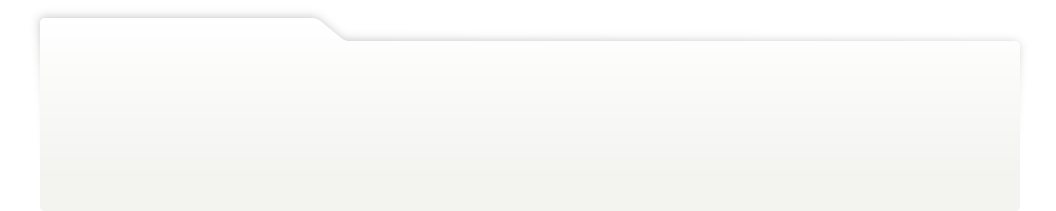
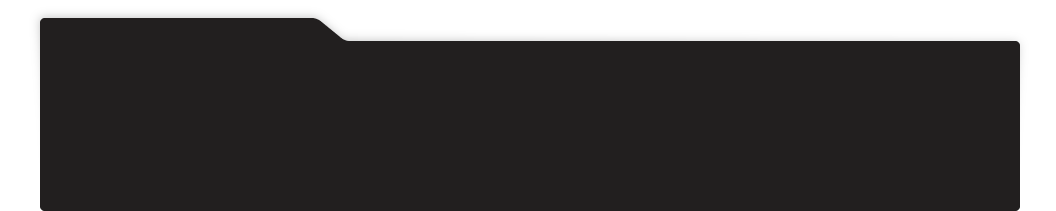
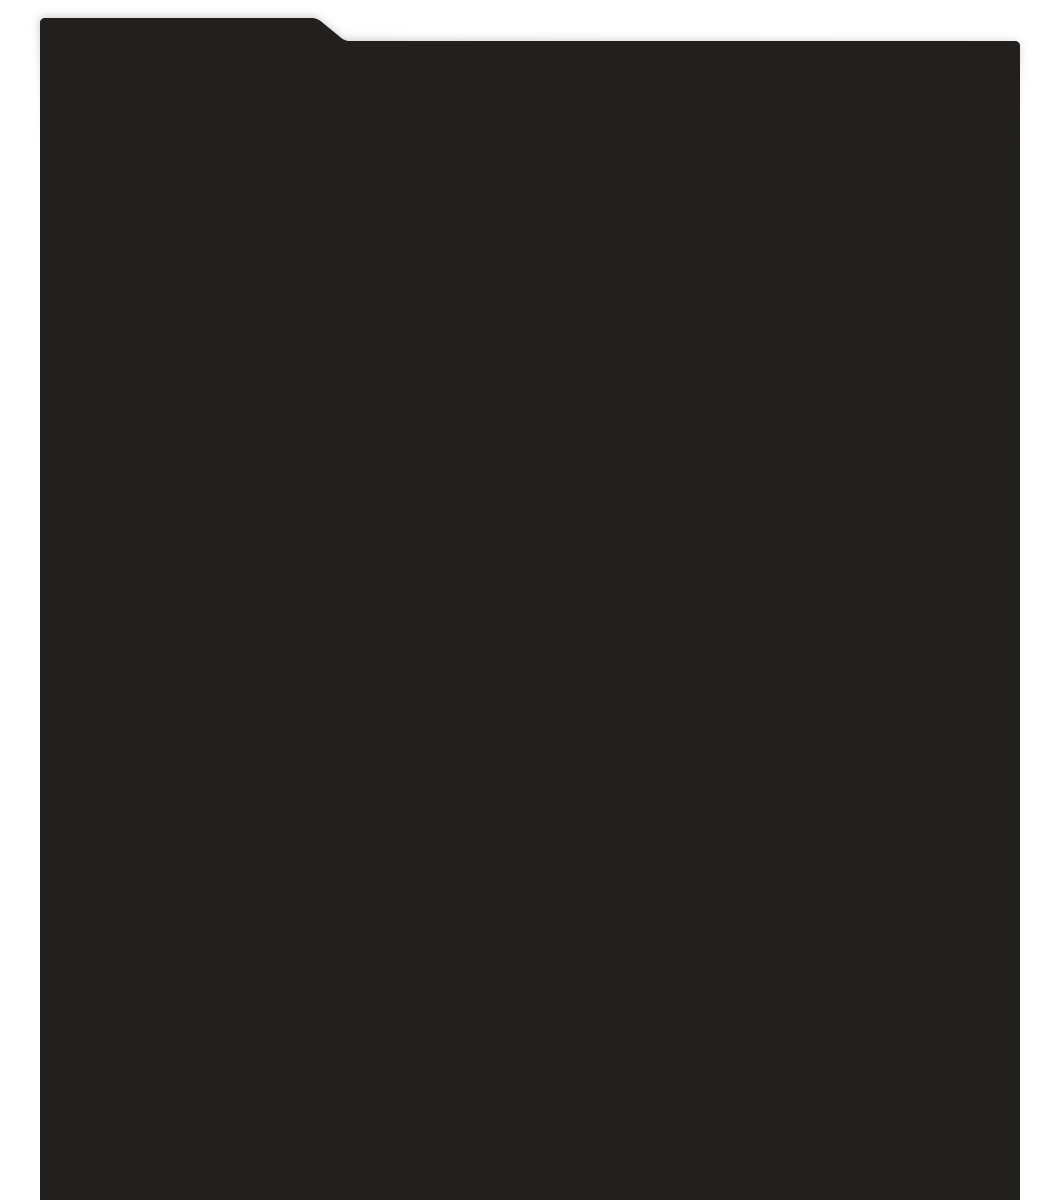
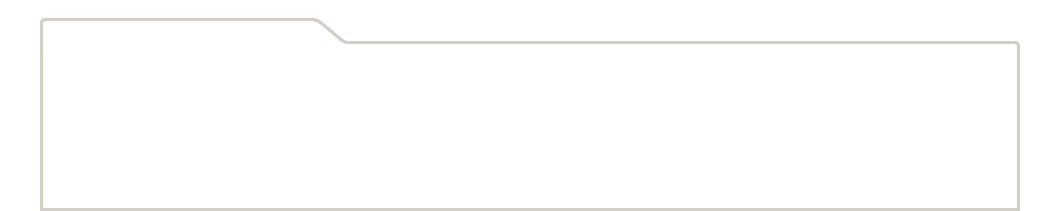
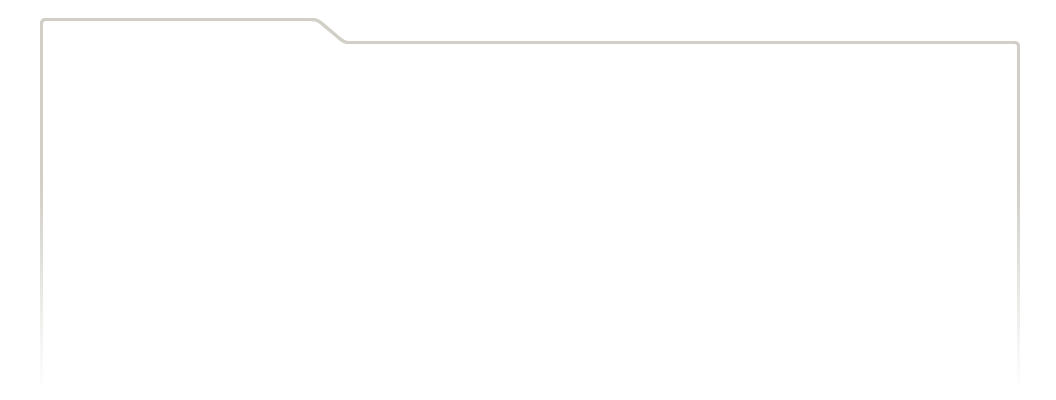
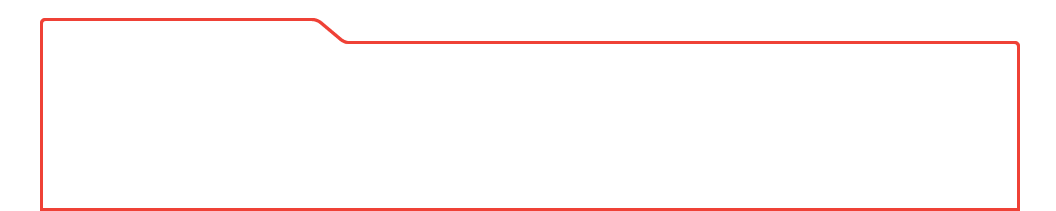
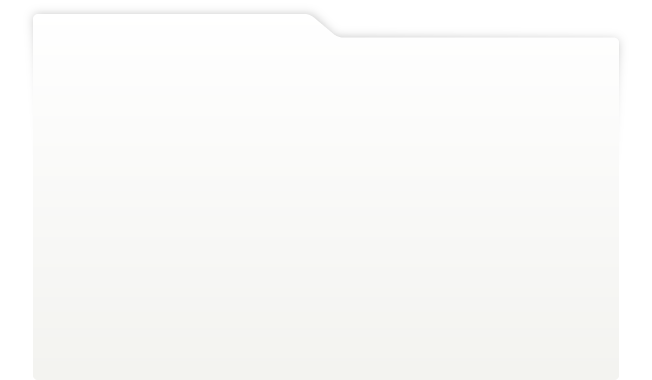
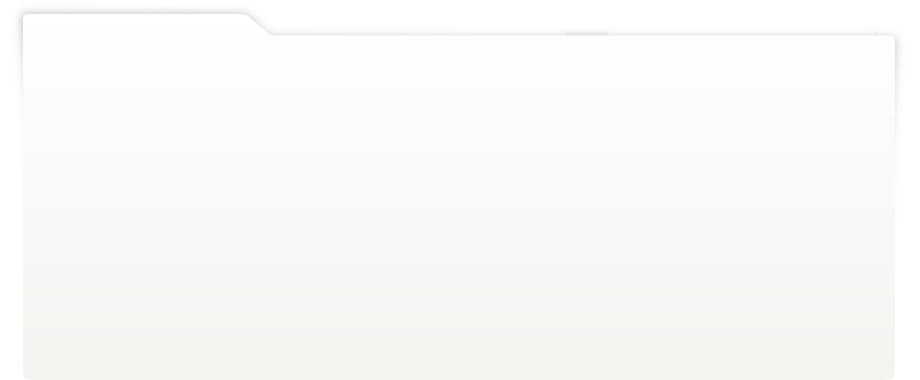
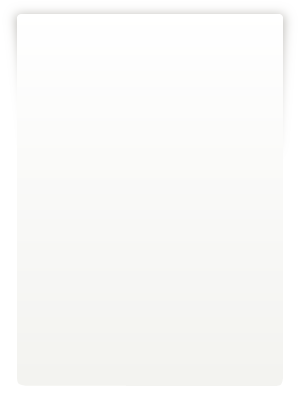
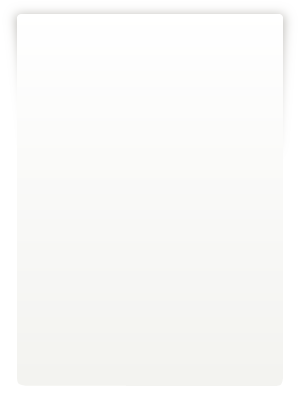
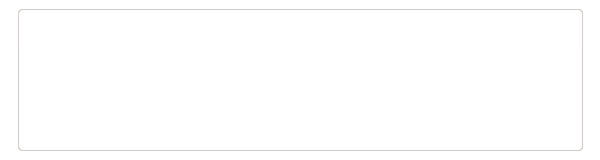
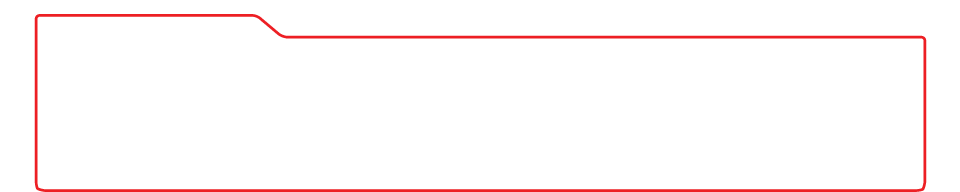
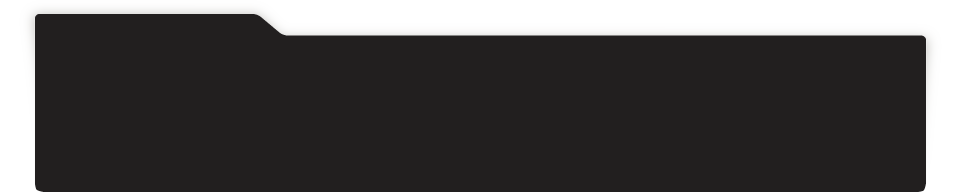
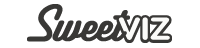
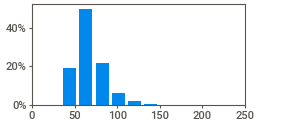
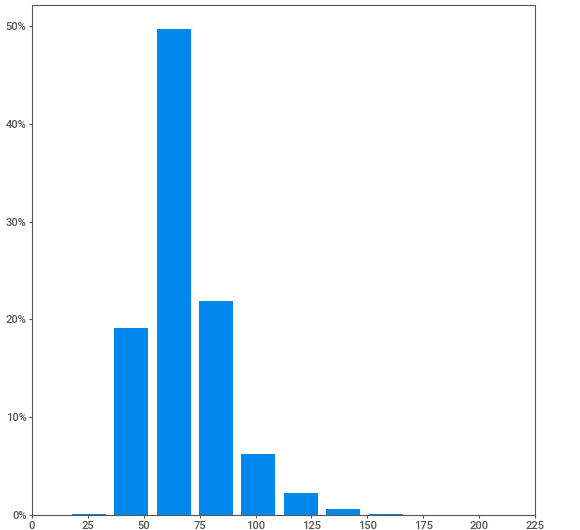
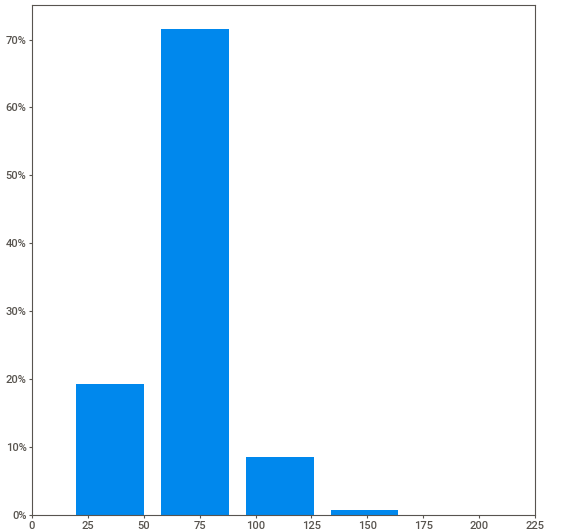
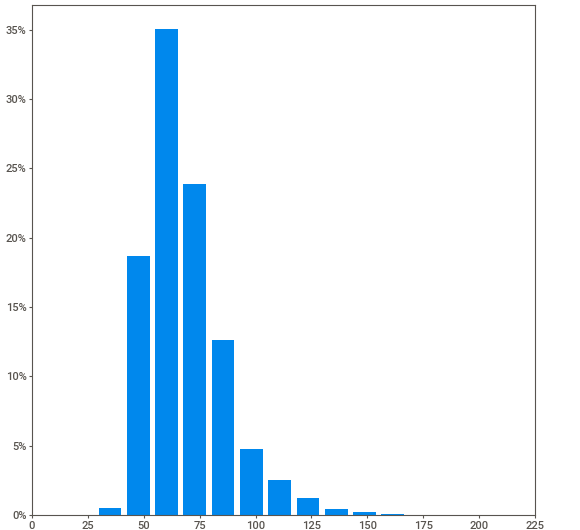
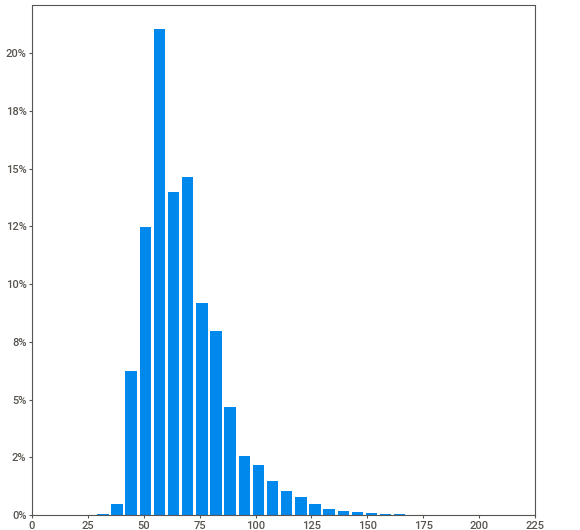
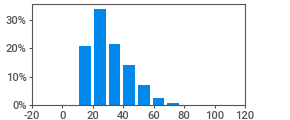
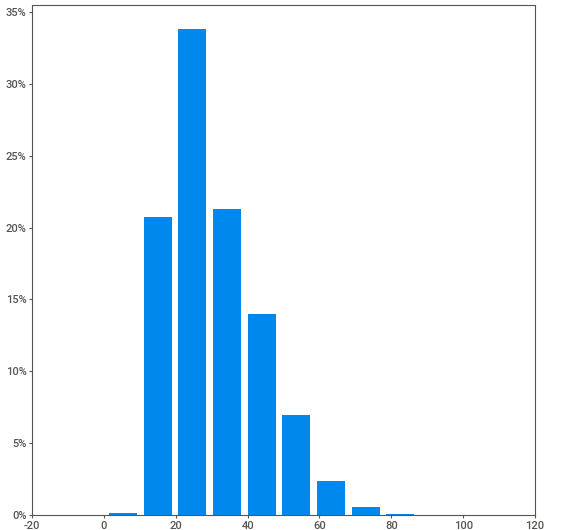
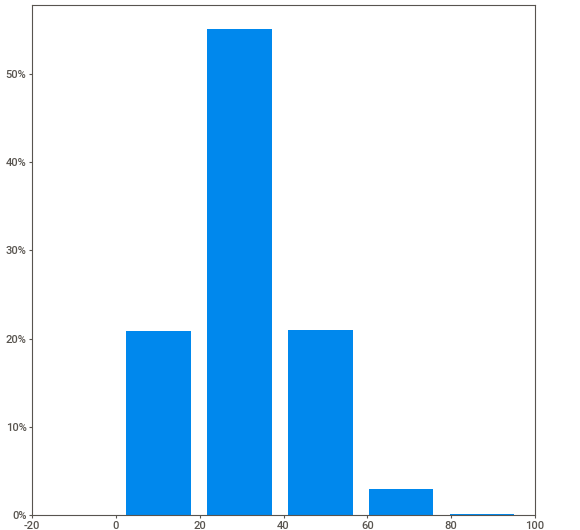
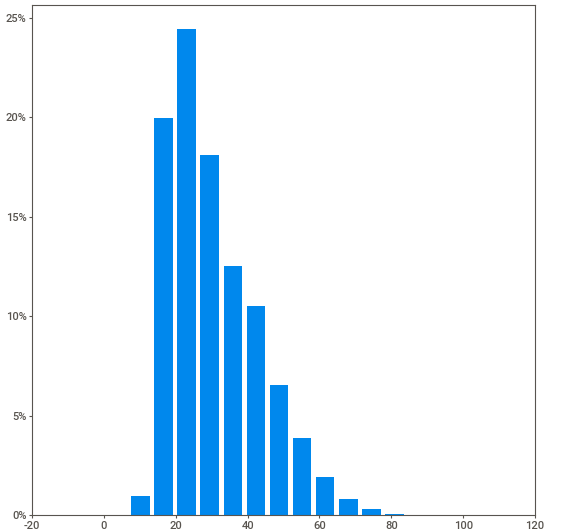
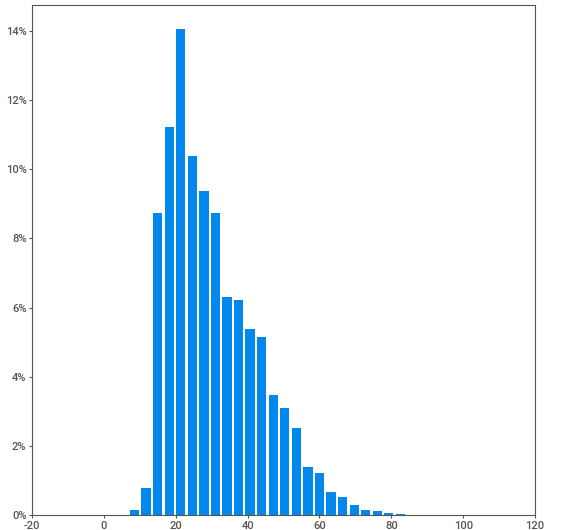
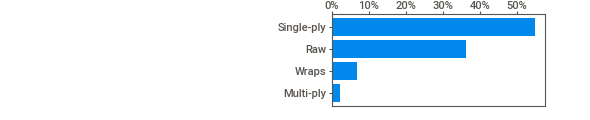
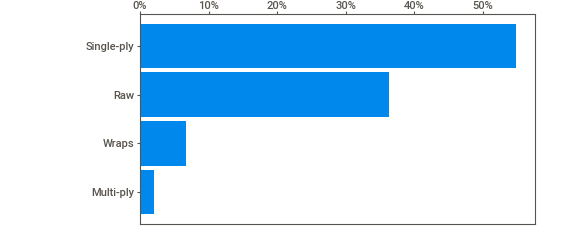
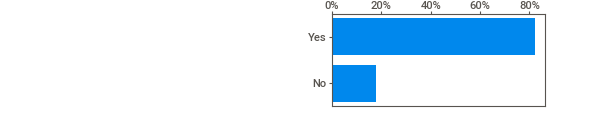
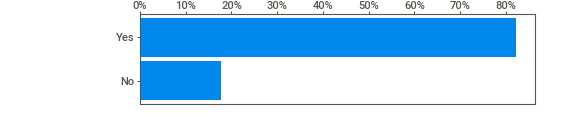
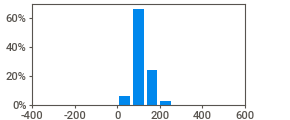
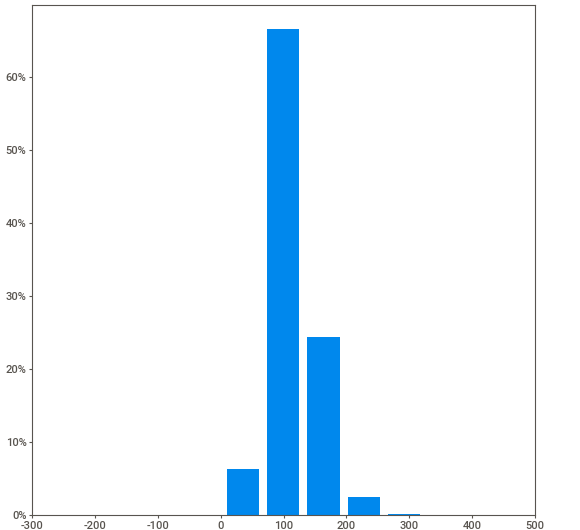
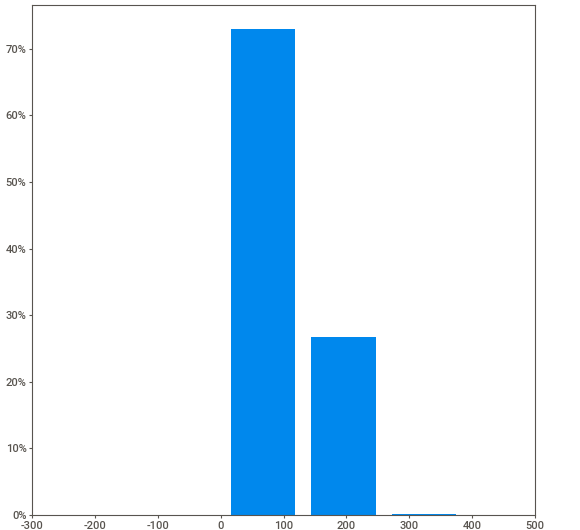
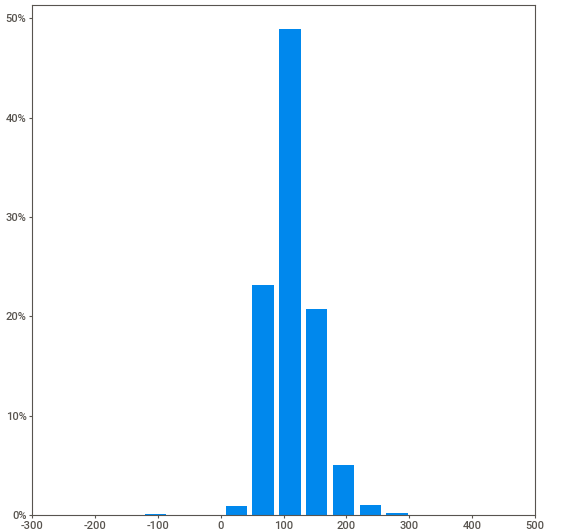
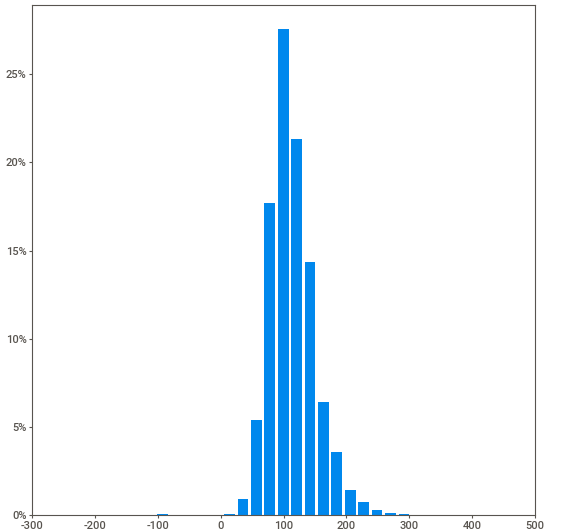
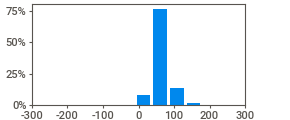
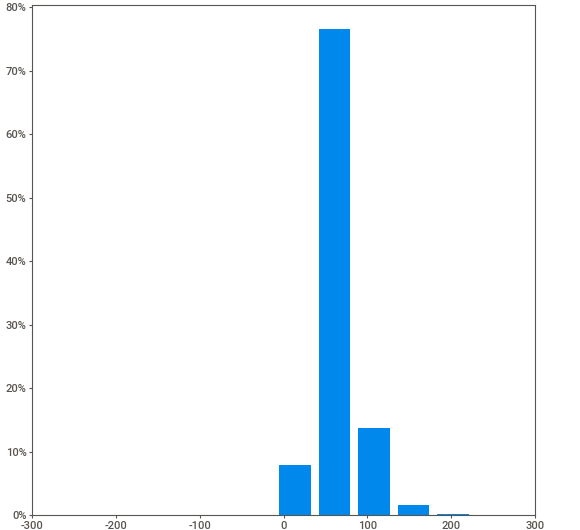
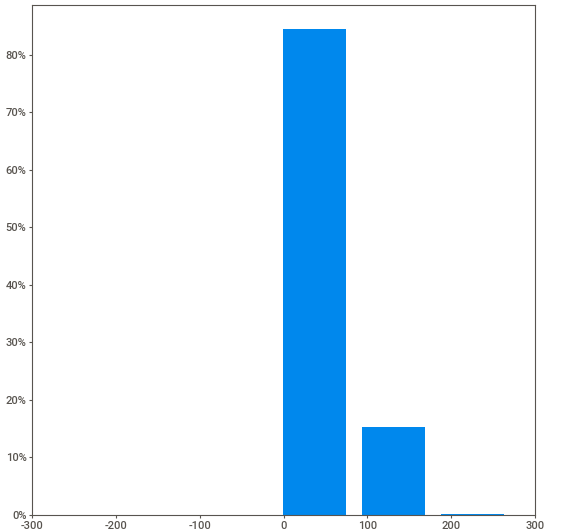
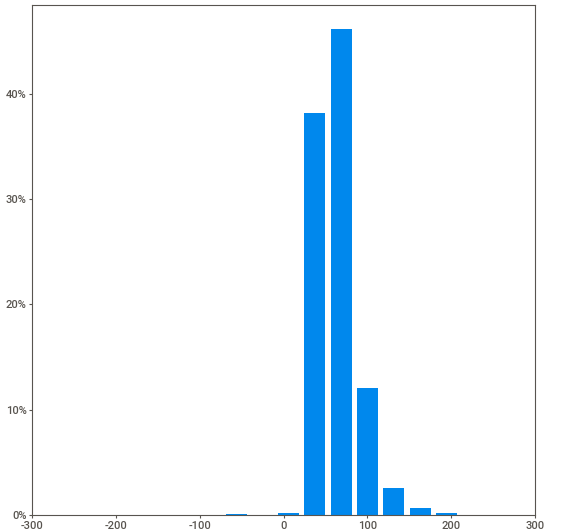
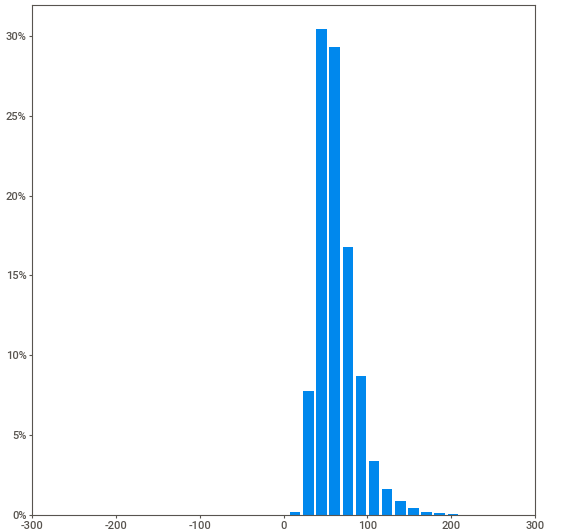
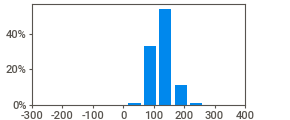
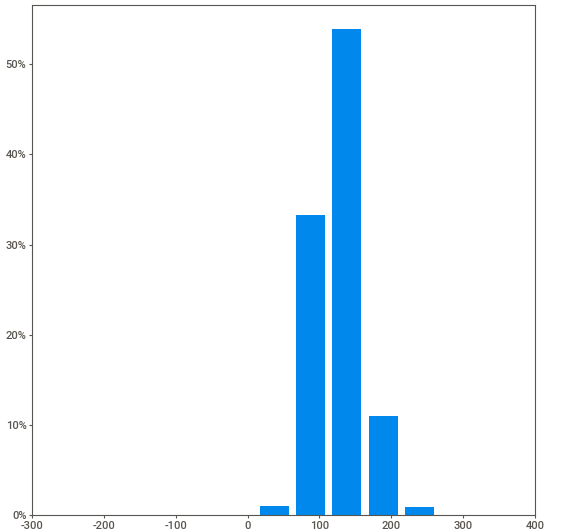
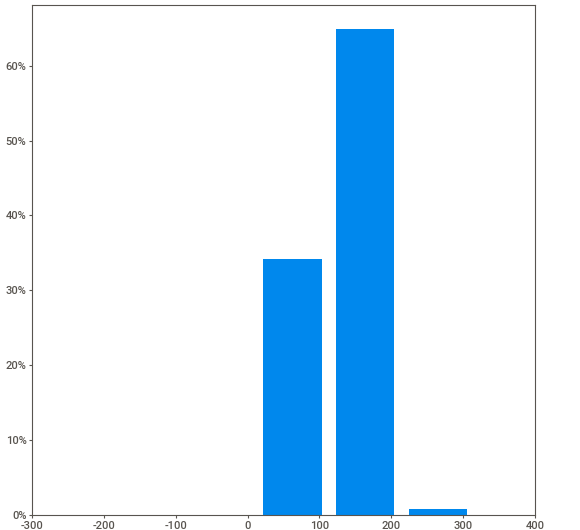
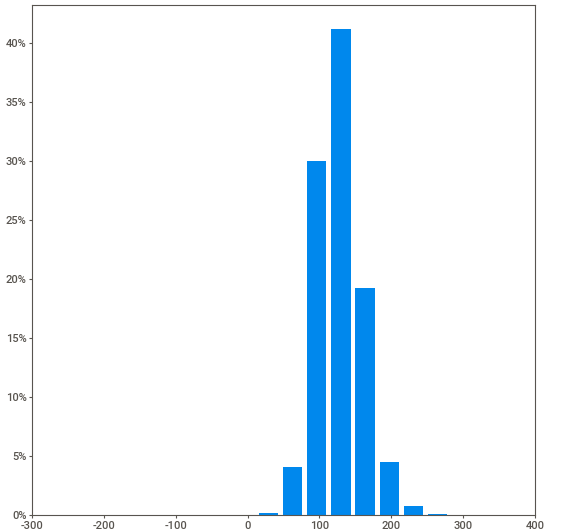
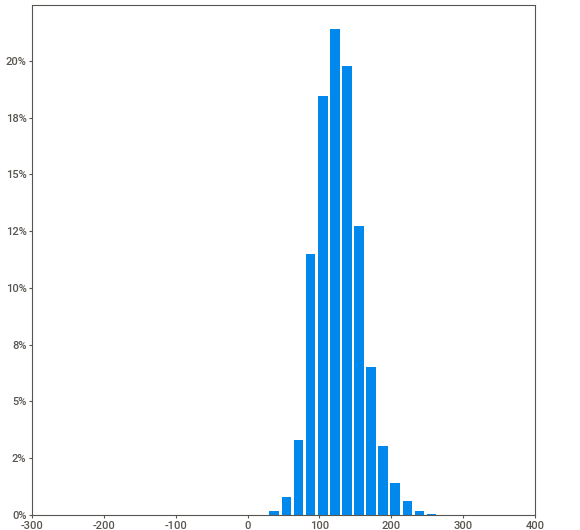
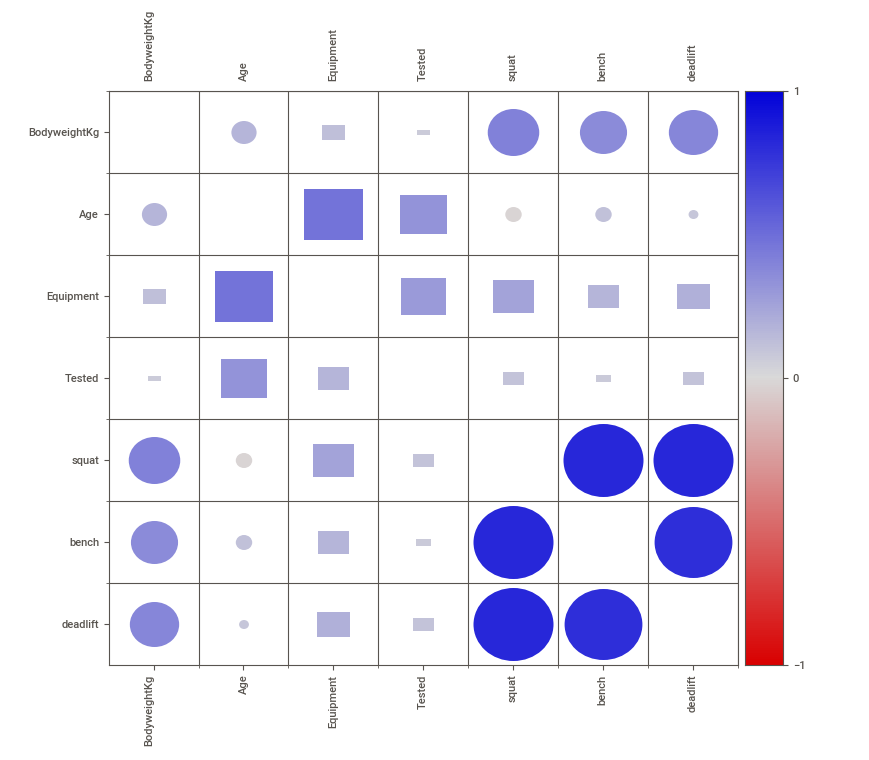
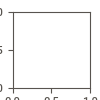

In [9]:
data_report = sv.analyze(df_regr)
data_report.show_notebook()

In [10]:
# Заменим все пропущенные значения и значения меньше 18 для колонки Возраст значением-меткой, -1
df_regr.loc[df_regr['Age'] < 18, 'Age'] = -1
# Неудачные 3 попытки выполнения упражнения заменим на 0
df_regr.loc[df_regr['bench'] < 0, 'bench'] = 0
df_regr.loc[df_regr['squat'] < 0, 'squat'] = 0
df_regr.loc[df_regr['deadlift'] < 0, 'deadlift'] = 0

# Заменим все пропущенные значения значением-меткой, -1
df_regr = df_regr.fillna({"bench":-1, "squat":-1, "deadlift": -1, 'Age': -1, "BodyweightKg": -1})

In [11]:
# Преобразование категориальных или текстовых данных в числа

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_regr['Equipment'] = le.fit_transform(df_regr['Equipment'])
df_regr['Tested'] = LabelEncoder().fit_transform(df_regr['Tested'])
output.clear()

## Регрессия на реальных данных

In [12]:
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# MAE, MAPE, MSE, RMSE, R2 реализовывал вручную, хотя нужно было лишь приглядеться к библиотекам sklearn
# def MAE(y_pred, y):
#   diff = y_pred - y
#   return sum(abs(diff)) / diff.size
  
# def MAPE(y_pred, y):
#   diff = (y - y_pred) / y
#   return sum(abs(diff)) / diff.size
  
# def MSE(y_pred, y):
#   diff = y_pred - y
#   return sum(diff**2) / diff.size
  
# def R2(y_pred, y):
#   return 1 - sum((y_pred - y)**2) / sum((y - np.mean(y))**2)

Построил по всем столбцам:

In [13]:
for column in df_regr.columns:
  X = df_regr.drop(column, axis = 1).to_numpy()
  y = df_regr[column].to_numpy()
  print(f'Столбец под названием "{column}"\n')

  res = sm.OLS(y, X).fit() # Использование statsmodels
  y_pred = res.predict(X)

  cv = KFold(n_splits=5) # Использование sklearn
  mean_mae = []
  mean_mape = []
  mean_mse = []
  mean_r2 = []
  for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    mean_mae.append(mean_absolute_error(y_test, model.predict(X_test)))
    mean_mape.append(mean_absolute_percentage_error(y_test, model.predict(X_test)))
    mean_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mean_r2.append(r2_score(y_test, model.predict(X_test)))
  
  print('    \t  Statsmodels \t\t  Sklearn')
  print(f' MAE \t{mean_absolute_error(y, y_pred)}\t{np.mean(mean_mae)}')
  print(f' MAPE \t{mean_absolute_percentage_error(y, y_pred)}\t{np.mean(mean_mape)}')
  print(f' MSE \t{mean_squared_error(y, y_pred)}\t{np.mean(mean_mse)}')
  print(f' RMSE \t{mean_squared_error(y, y_pred)**0.5}\t{np.mean(mean_mse)**0.5}')
  print(f' R2 \t{r2_score(y, y_pred)}\t{np.mean(mean_r2)}\n\n')

Столбец под названием "BodyweightKg"

    	  Statsmodels 		  Sklearn
 MAE 	16.53009332352003	13.367546681212588
 MAPE 	0.8257217677949059	0.8883579136757099
 MSE 	475.2664807912012	336.3574949735488
 RMSE 	21.80060734913597	18.340051662237727
 R2 	-0.3161762261686485	0.06115533467165331


Столбец под названием "Age"

    	  Statsmodels 		  Sklearn
 MAE 	14.018852354737973	14.702794711445403
 MAPE 	6.760132011389063	7.394945854349807
 MSE 	294.4260702404398	310.1473213368491
 RMSE 	17.158848161821346	17.6110000095636
 R2 	0.15967574228909265	-9.81666832151529


Столбец под названием "Equipment"

    	  Statsmodels 		  Sklearn
 MAE 	0.5529202602652696	0.4993186393134801
 MAPE 	116127038241313.75	148524632707208.84
 MSE 	0.49552286490729924	0.3873574443659566
 RMSE 	0.7039338498092695	0.6223804659257524
 R2 	-0.23889606426131693	-0.08169038737498244


Столбец под названием "Tested"

    	  Statsmodels 		  Sklearn
 MAE 	0.3211702080837063	0.275256732310748
 MAPE 	582493224506884.0	60853411

Для меня стало удивлением, что только присед и становую тягу удалось успешно определять линейной регрессией (R2 > 0.5). Это может означать слабость линейной зависимости в других критериях, но не исключает нелинейныеЮ которые будут способны выставить верную корреляцию.

По параметру возраста можно наблюдать, насколько слабо разнится среднеквадратическая ошибка, но сильно влияет на R2: у statsmodel 0.1597, а у sklearn -9.8167.

# Задание 2

Попробовать исключить все пропущенные данные из набора и решить на них задачу регрессии на любой целевой переменной и попробовать различные методы нормализации/стандартизации данных (MinMaxScaler, RobustScaler, StandardScaler)


Строить регрессию как на всех данных целиком с помощью statsmodels, так и с помощью кросс-валидации и пакета sklearn (встроенная модель LinearRegression)  (попробовать оба варианта)

## Удаление пустых значений и повторный анализ

                                             |          | [  0%]   00:00 -> (? left)


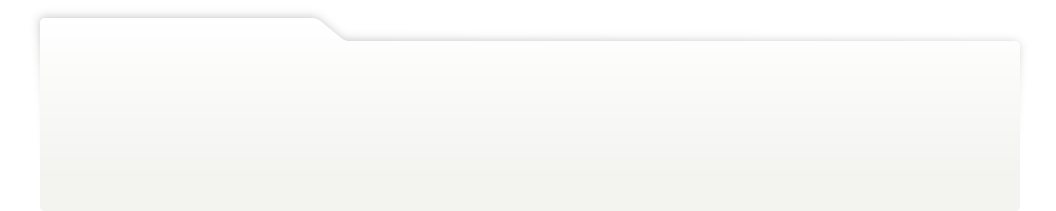
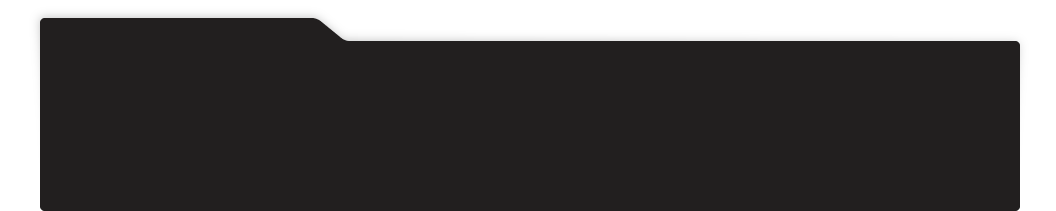
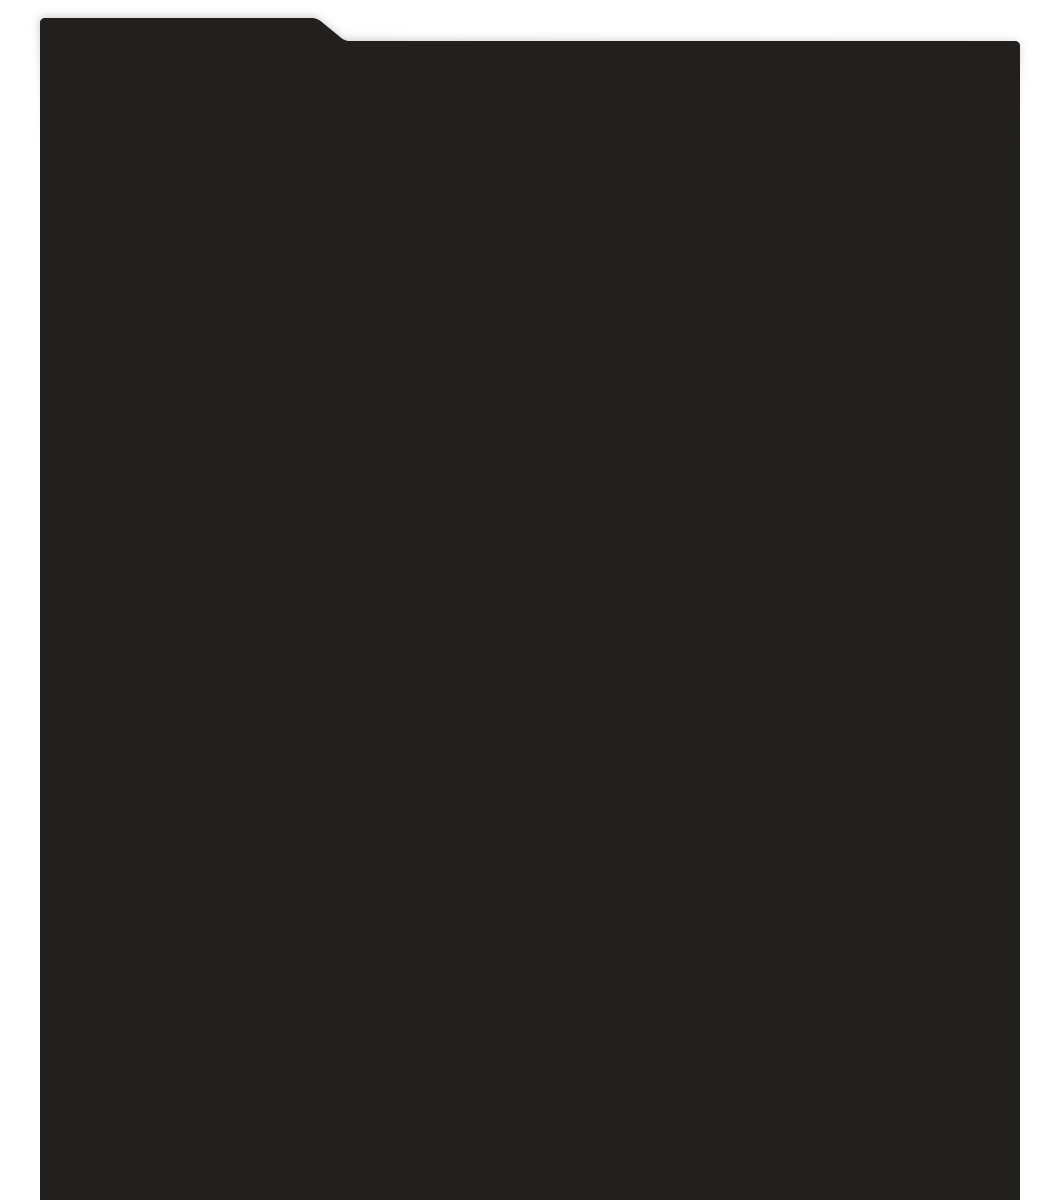
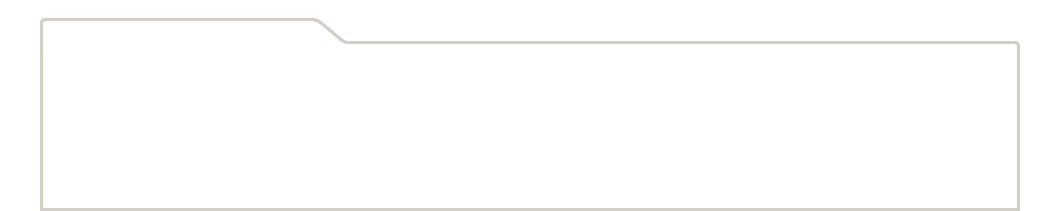
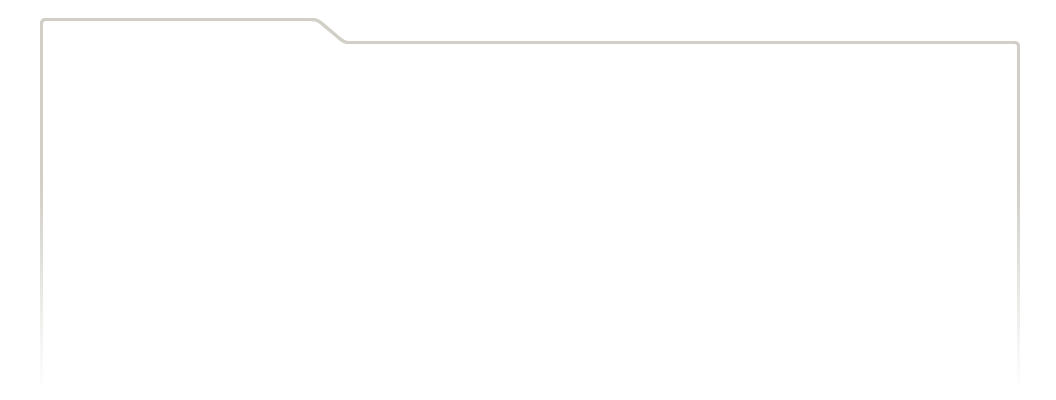
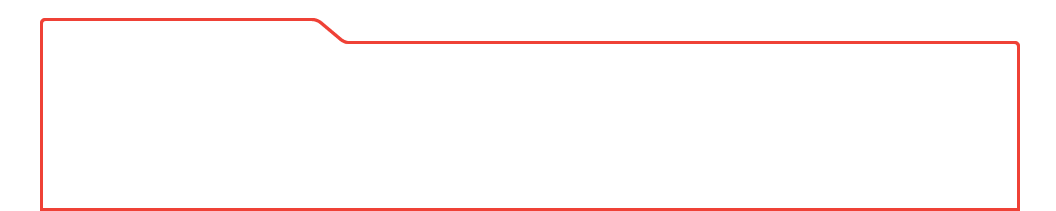
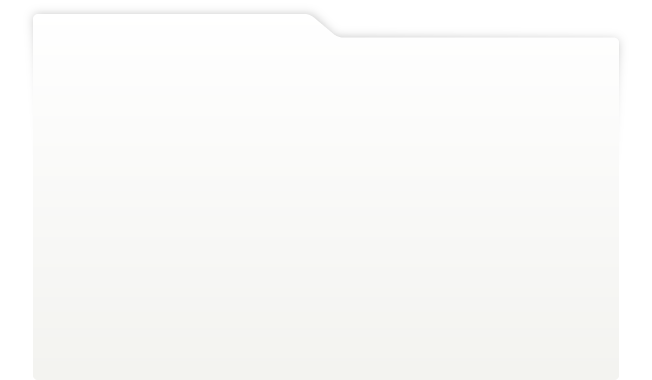
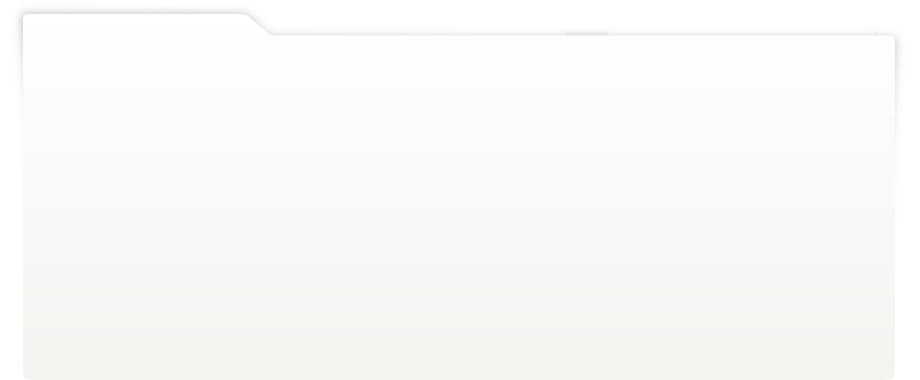
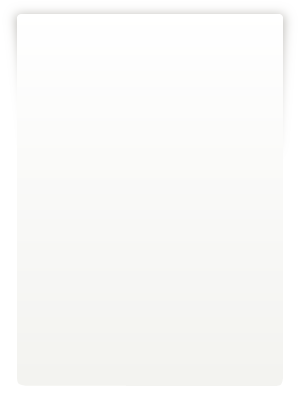
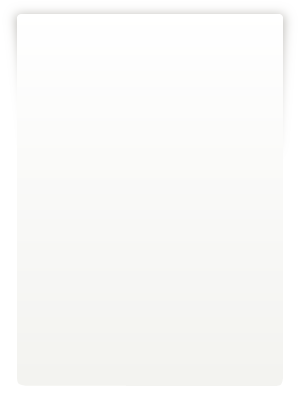
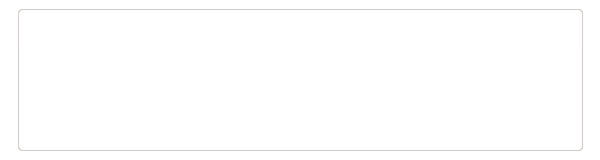
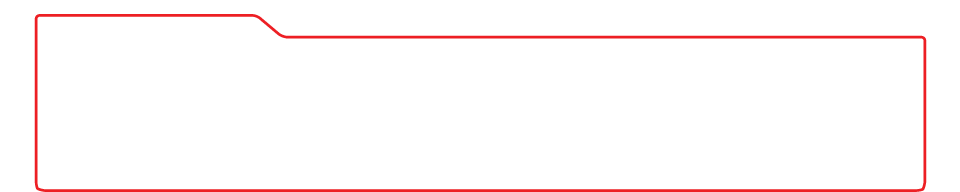
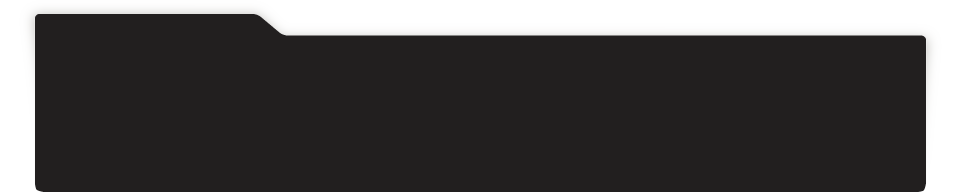
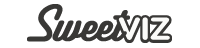
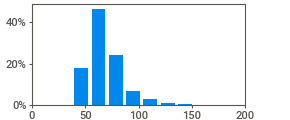
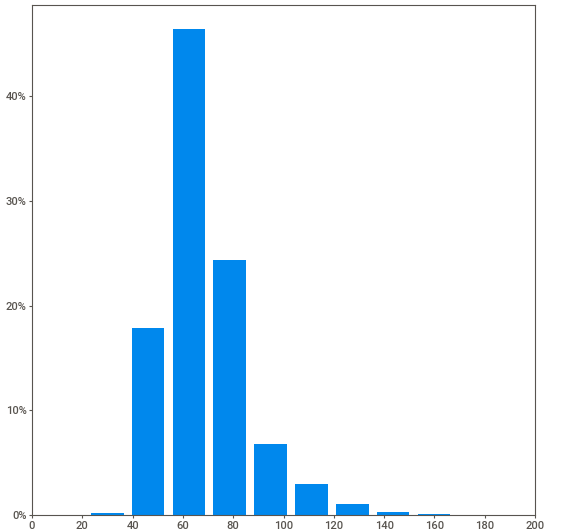
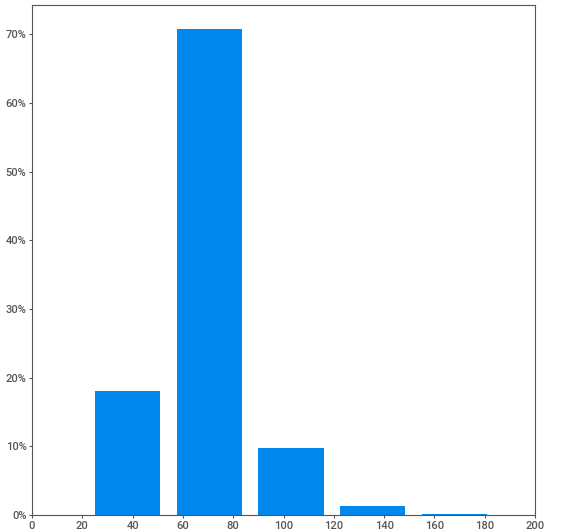
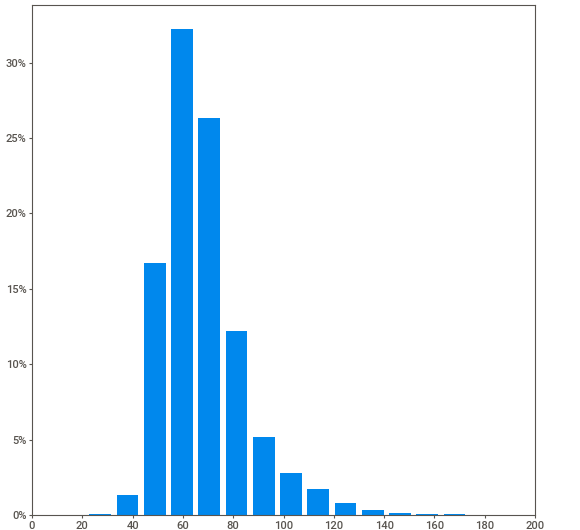
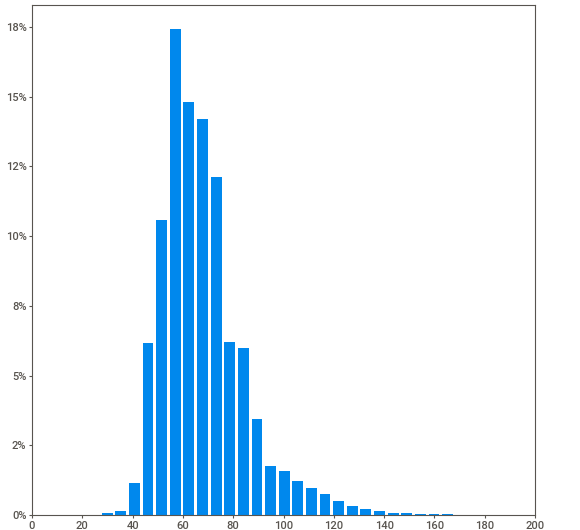
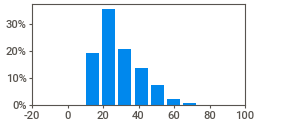
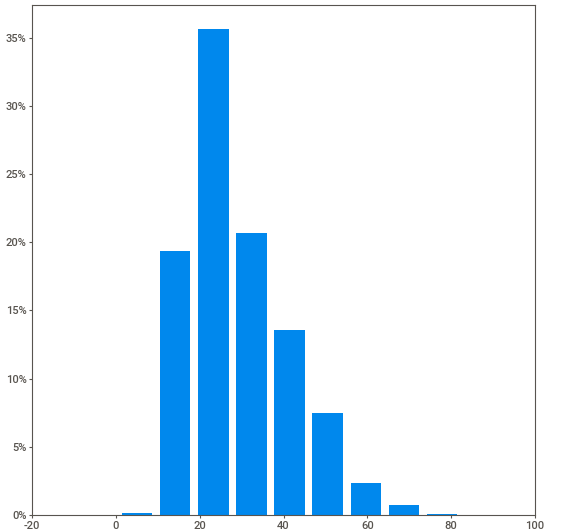
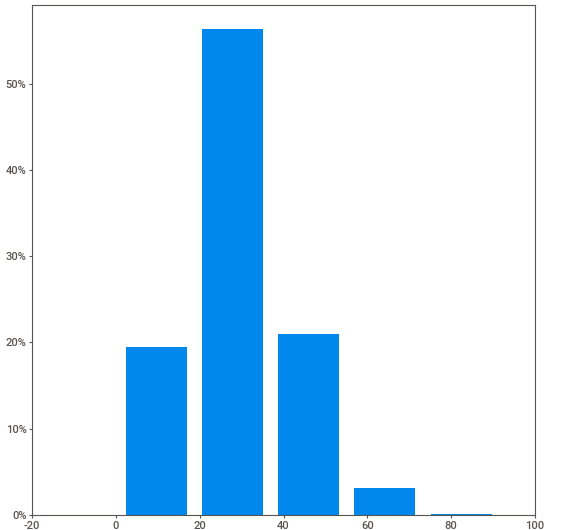
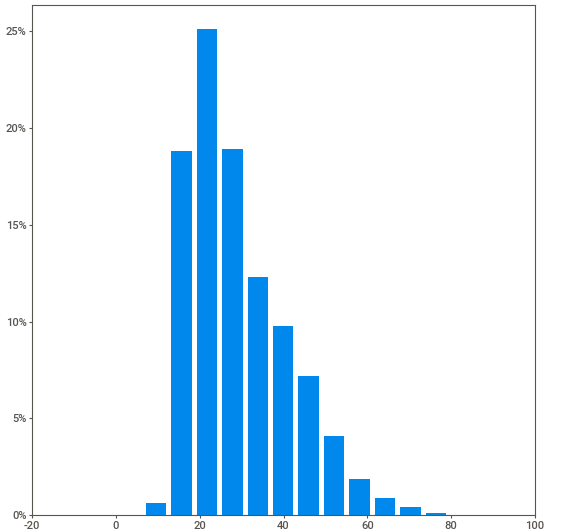
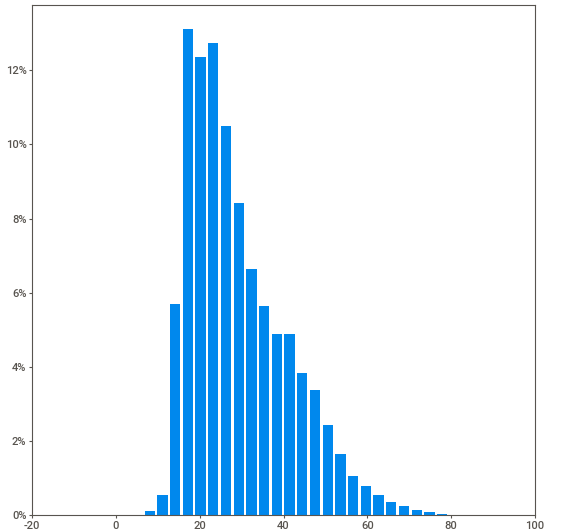
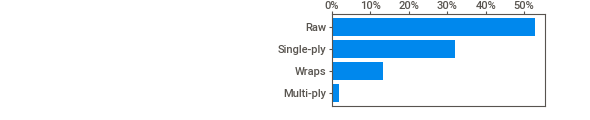
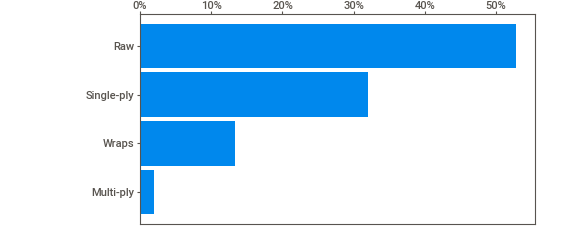
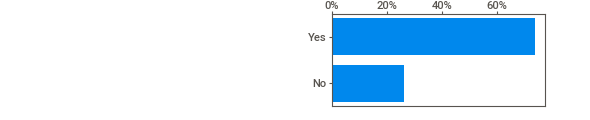
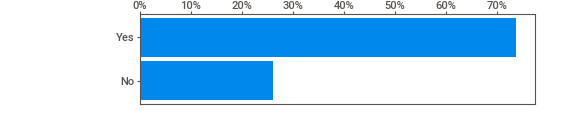
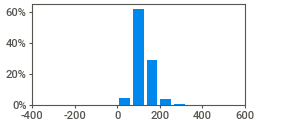
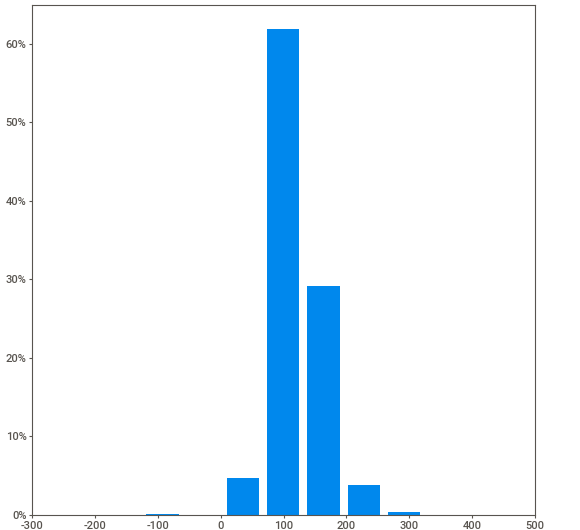
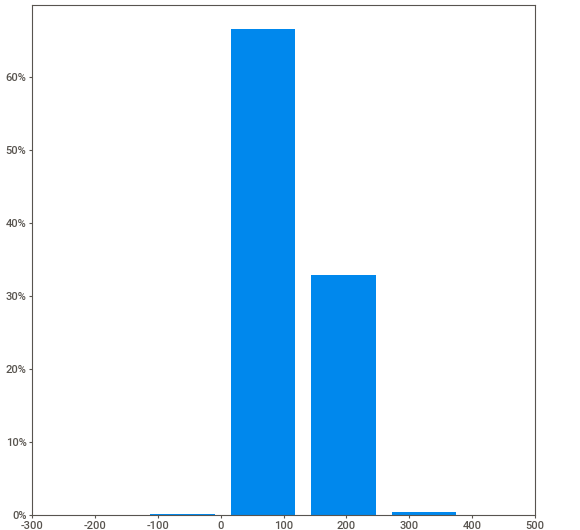
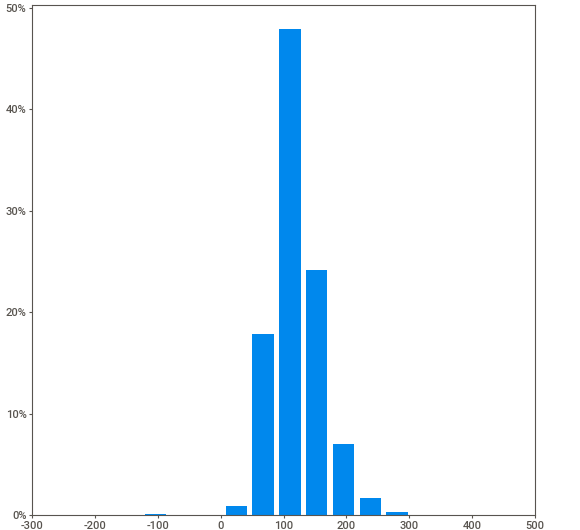
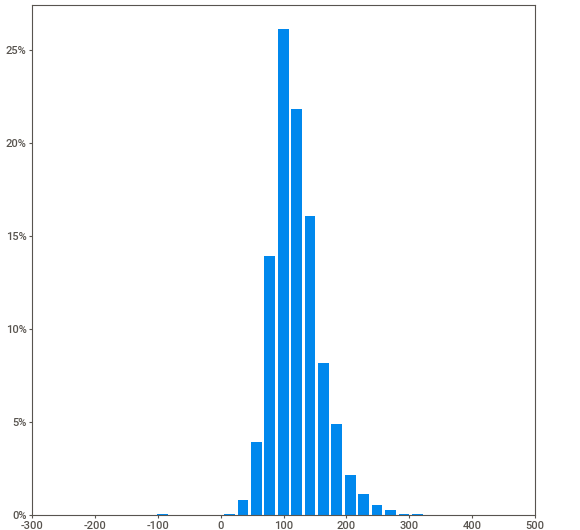
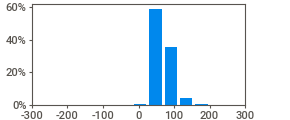
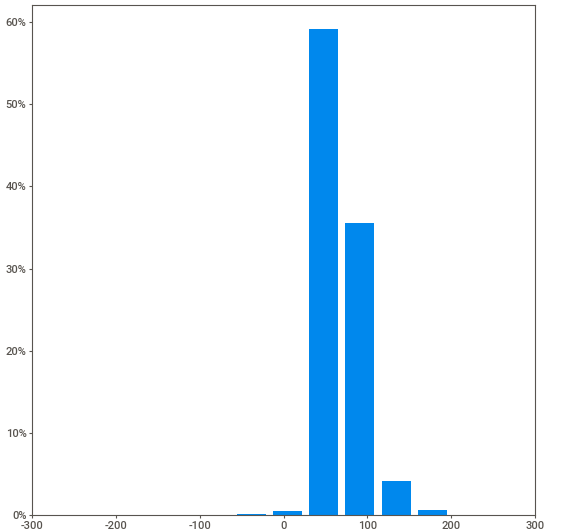
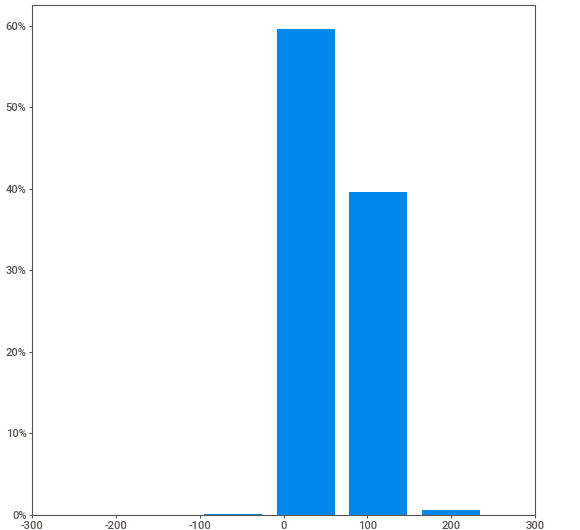
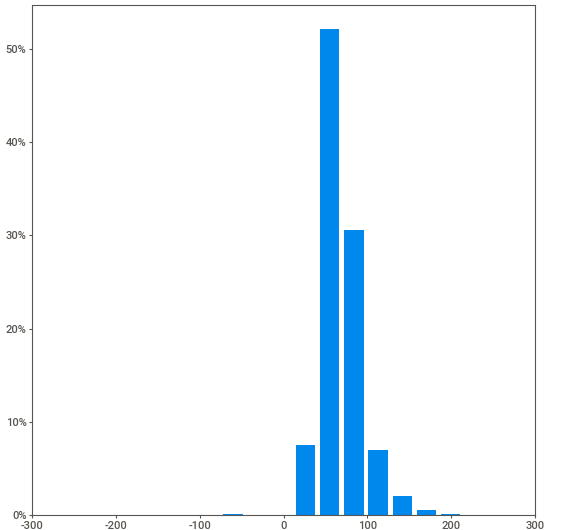
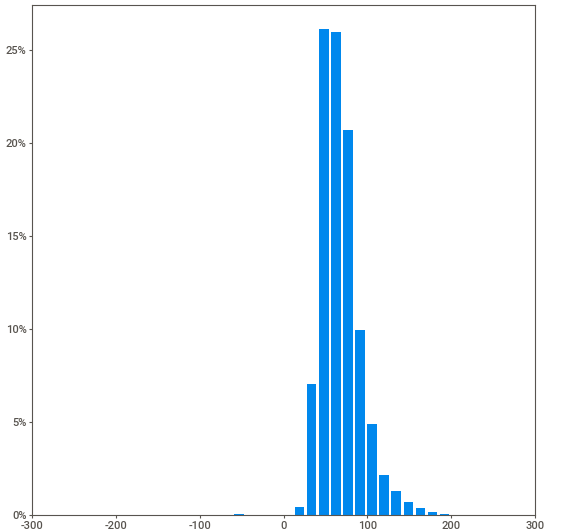
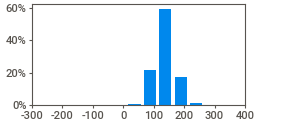
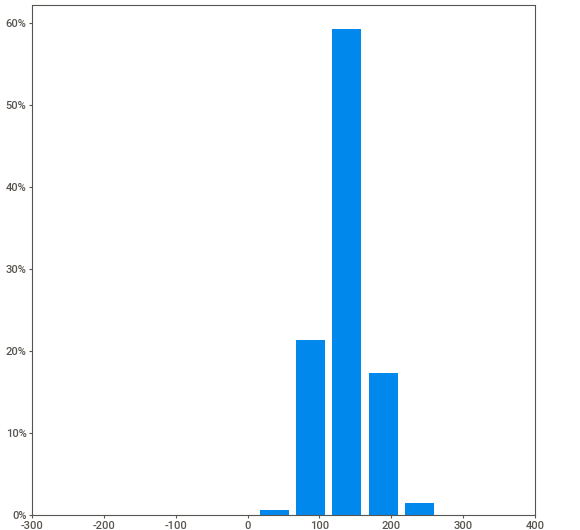
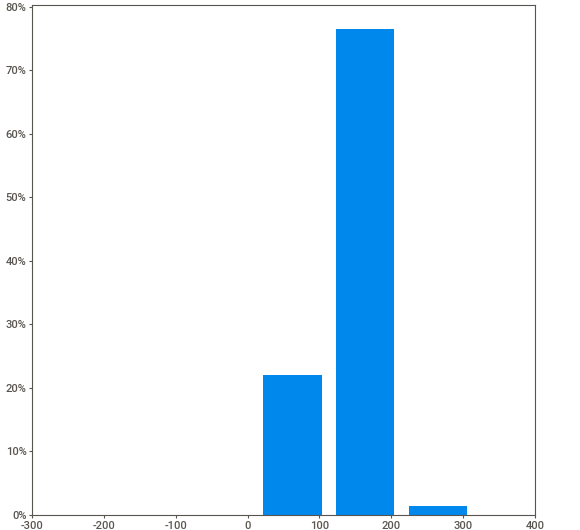
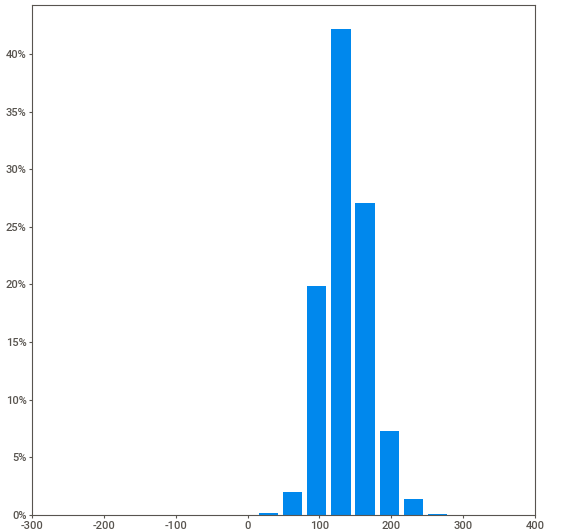
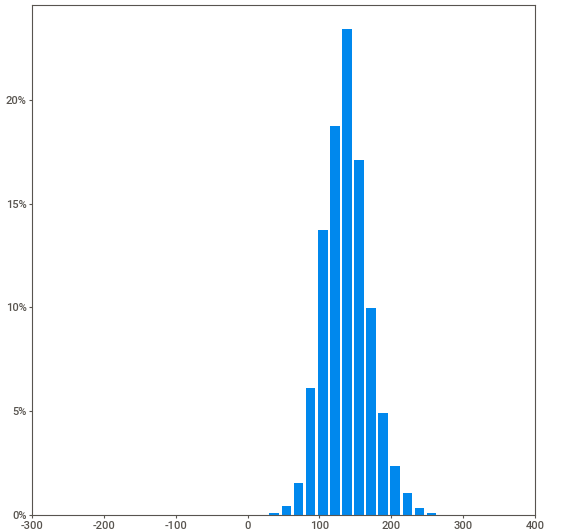
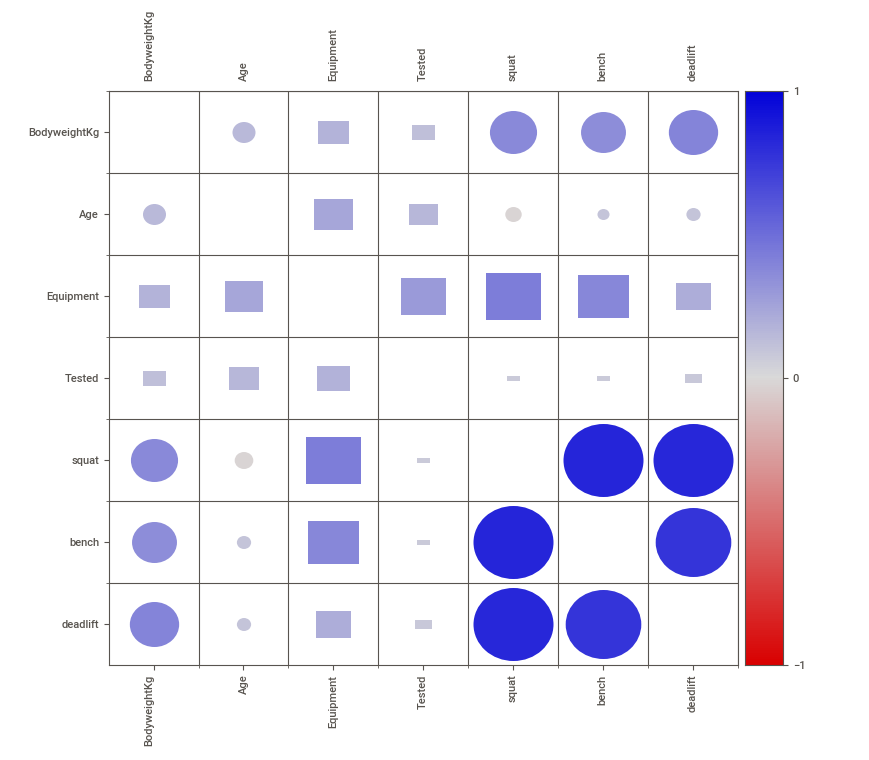
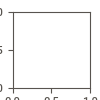

In [14]:
df_regr = df[["BodyweightKg", "Age", "Equipment", "Tested", "Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]]
df_regr.loc[df['Tested'] != 'Yes', 'Tested'] = "No"
df_regr = df_regr.rename(columns={"Best3BenchKg": "bench", "Best3SquatKg": "squat", "Best3DeadliftKg": "deadlift"})

df_regr = df_regr.dropna(axis=0,inplace=False)
data_report = sv.analyze(df_regr)
data_report.show_notebook()

In [15]:
le = LabelEncoder()
df_regr['Equipment'] = le.fit_transform(df_regr['Equipment'])
df_regr['Tested'] = LabelEncoder().fit_transform(df_regr['Tested'])
output.clear()

## Регрессия
Нормализация разными способами, но теперь только с RMSE и R2

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

print('В данном блоке используется MinMaxScaler\n')
scaler = MinMaxScaler()

for column in df_regr.columns:
  X = df_regr.drop(column, axis = 1).to_numpy()
  y = df_regr[column].to_numpy()
  print(f'Столбец под названием "{column}"')

  X_trans = scaler.fit_transform(X)
  res = sm.OLS(y, X_trans).fit() # Использование statsmodels
  y_pred = res.predict(X_trans)

  cv = KFold(n_splits=5) # Использование sklearn
  mean_mse = []
  mean_r2 = []
  for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LinearRegression()
    model.fit(X_train, y_train)
    mean_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mean_r2.append(r2_score(y_test, model.predict(X_test)))
  
  print('    \t  Statsmodels \t\t  Sklearn')
  print(f' RMSE \t{mean_squared_error(y, y_pred)**0.5}\t{np.mean(mean_mse)**0.5}')
  print(f' R2 \t{r2_score(y, y_pred)}\t{np.mean(mean_r2)}\n')

В данном блоке используется MinMaxScaler

Столбец под названием "BodyweightKg"
    	  Statsmodels 		  Sklearn
 RMSE 	15.360599704480613	15.519382701152454
 R2 	0.1570367272134392	0.13509386457537367

Столбец под названием "Age"
    	  Statsmodels 		  Sklearn
 RMSE 	11.370190394175479	11.224171699392596
 R2 	0.05697989234700551	0.07764575861135589

Столбец под названием "Equipment"
    	  Statsmodels 		  Sklearn
 RMSE 	0.7180528843810398	0.7485348435418369
 R2 	0.06208473974511297	-0.15596017552870065

Столбец под названием "Tested"
    	  Statsmodels 		  Sklearn
 RMSE 	0.43352622764795756	0.44785061742739674
 R2 	0.027602671133083567	-0.22527825656870873

Столбец под названием "squat"
    	  Statsmodels 		  Sklearn
 RMSE 	28.214332520764138	17.88882124871894
 R2 	0.47423961072745846	0.7808383739402311

Столбец под названием "bench"
    	  Statsmodels 		  Sklearn
 RMSE 	18.04094076979558	13.0559921337967
 R2 	0.42856814022707423	0.6908363103861486

Столбец под названием "deadlift"
    	

In [20]:
print('В данном блоке используется StandardScaler\n')
scaler = StandardScaler()

for column in df_regr.columns:
  X = df_regr.drop(column, axis = 1).to_numpy()
  y = df_regr[column].to_numpy()
  print(f'Столбец под названием "{column}"')

  X_trans = scaler.fit_transform(X)
  res = sm.OLS(y, X_trans).fit() # Использование statsmodels
  y_pred = res.predict(X_trans)

  cv = KFold(n_splits=5) # Использование sklearn
  mean_mse = []
  mean_r2 = []
  for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LinearRegression()
    model.fit(X_train, y_train)
    mean_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mean_r2.append(r2_score(y_test, model.predict(X_test)))
  
  print('    \t  Statsmodels \t\t  Sklearn')
  print(f' RMSE \t{mean_squared_error(y, y_pred)**0.5}\t{np.mean(mean_mse)**0.5}')
  print(f' R2 \t{r2_score(y, y_pred)}\t{np.mean(mean_r2)}\n')

В данном блоке используется StandardScaler

Столбец под названием "BodyweightKg"
    	  Statsmodels 		  Sklearn
 RMSE 	69.4482818262022	15.519382701151368
 R2 	-16.231191980944153	0.13509386457549705

Столбец под названием "Age"
    	  Statsmodels 		  Sklearn
 RMSE 	31.345677100502414	11.224171699392972
 R2 	-6.167055871966952	0.07764575861129046

Столбец под названием "Equipment"
    	  Statsmodels 		  Sklearn
 RMSE 	1.7213143998920244	0.7485348435418309
 R2 	-4.389781305816923	-0.15596017552862493

Столбец под названием "Tested"
    	  Statsmodels 		  Sklearn
 RMSE 	0.8527160719949427	0.4478506174273955
 R2 	-2.7620269381292273	-0.2252782565685441

Столбец под названием "squat"
    	  Statsmodels 		  Sklearn
 RMSE 	121.74867282020737	17.88882124871806
 R2 	-8.789866595636687	0.7808383739402437

Столбец под названием "bench"
    	  Statsmodels 		  Sklearn
 RMSE 	69.08883739956428	13.055992133800586
 R2 	-7.380344236150625	0.6908363103860149

Столбец под названием "deadlift"
    	  Sta

In [21]:
print('В данном блоке используется RobustScaler\n')
scaler = RobustScaler()

for column in df_regr.columns:
  X = df_regr.drop(column, axis = 1).to_numpy()
  y = df_regr[column].to_numpy()
  print(f'Столбец под названием "{column}"')

  X_trans = scaler.fit_transform(X)
  res = sm.OLS(y, X_trans).fit() # Использование statsmodels
  y_pred = res.predict(X_trans)

  cv = KFold(n_splits=5) # Использование sklearn
  mean_mse = []
  mean_r2 = []
  for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LinearRegression()
    model.fit(X_train, y_train)
    mean_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mean_r2.append(r2_score(y_test, model.predict(X_test)))
  
  print('    \t  Statsmodels \t\t  Sklearn')
  print(f' RMSE \t{mean_squared_error(y, y_pred)**0.5}\t{np.mean(mean_mse)**0.5}')
  print(f' R2 \t{r2_score(y, y_pred)}\t{np.mean(mean_r2)}\n')

В данном блоке используется RobustScaler

Столбец под названием "BodyweightKg"
    	  Statsmodels 		  Sklearn
 RMSE 	50.763377965694836	15.519382701151379
 R2 	-8.206474137810043	0.135093864575496

Столбец под названием "Age"
    	  Statsmodels 		  Sklearn
 RMSE 	23.76254137840584	11.22417169939297
 R2 	-3.118805190173921	0.07764575861129046

Столбец под названием "Equipment"
    	  Statsmodels 		  Sklearn
 RMSE 	1.4014887120374688	0.7485348435418285
 R2 	-2.572974759845504	-0.15596017552862101

Столбец под названием "Tested"
    	  Statsmodels 		  Sklearn
 RMSE 	0.7447643587909089	0.4478506174273956
 R2 	-1.8697943335731977	-0.2252782565685521

Столбец под названием "squat"
    	  Statsmodels 		  Sklearn
 RMSE 	85.01568782848396	17.8888212487181
 R2 	-3.7736046535052727	0.7808383739402428

Столбец под названием "bench"
    	  Statsmodels 		  Sklearn
 RMSE 	48.904872795767055	13.055992133800586
 R2 	-3.19904333213373	0.6908363103860149

Столбец под названием "deadlift"
    	  Statsmode

Удалённые строки забрали с собой больше половины всей выборки, но нельзя назвать количество в более, чем 130к экземпляров , совсем малой.

Каждый из способов нормализации в целом смог повысить точность регрессии, что отчётливо видно для Sklearn и столбца жима лёжа (0.17 -> 0.69). Но и не стоит совсем безосновательно использовать нормализацию. Так на критерий Tested он повлиял в худшую сторону (0.37 -> -0.22), но и сама задача определения допинг-контроля по остальным параметрам не кажется такой уж тривиально зависимой от веса участника и его результатов.

Для Statsmodels нормализация сказалась в худшую сторону, но это может быть последствием отсутствия кросс-валидации, из-за чего нормализация была воспринята моделью некорректно.

# Задание 3 (Дополнительное, продвинутое)

Попробовать предсказать значение курса биткоина по курсу доллара или иной валюты. Для сбора данных можно использовать этот пакет - https://github.com/ranaroussi/yfinance

Надеюсь, я вернусь и попробую, когда появится чуть больше времени...